In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import conntility

In [2]:
import bluepysnap as bp
path_to_simulation = './0/'
s = bp.Simulation(path_to_simulation+'simulation_config.json') # Loads simulation object
# population_name = s.reports['lfp_report'].population_names[0]

# r  = s.reports['lfp_report'][population_name]

In [3]:
circuit = s.circuit

In [4]:
nodes = circuit.nodes

In [5]:
nFl = nodes.get('S1FL',properties=['mtype'])

In [6]:
Fl = next(nFl)[1]
Fl = np.array(list(Fl[Fl['mtype']=='L5_TPC:A'].index))[:,1].astype(int)

In [7]:
import h5py

coeffsFile = "/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/coeffs_neuropixels_objective.h5"

coeffs = h5py.File(coeffsFile)

In [8]:
allNodeIds = coeffs['S1nonbarrel_neurons']['node_ids']

In [16]:
FLshort = allNodeIds[:][flIndex]

In [9]:
flIndex = np.where(np.isin(allNodeIds[:],Fl))[0]


In [10]:
np.random.seed(1776)

# Samples nodes from the selected regions

flIndex = np.sort(np.random.choice(flIndex,1000,replace=False))

In [11]:
flOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex+1]]


In [12]:
lfpIdx = np.arange(51)
sphere_fullDensity_idx = np.arange(51,102)
disk_fullDensity_idx = np.arange(102,153)
sphere_halfDensity_idx = np.arange(153,179)
disk_halfDensity_idx = np.arange(179,205)
sphere_quarterDensity_idx = np.arange(205,218)
disk_quarterDensity_idx = np.arange(218,231)

In [13]:
SphereFull = []
SphereHalf = []
SphereQuarter = []
DiskFull = []
DiskHalf = []
DiskQuarter = []

for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,sphere_fullDensity_idx]
    sfl -= np.min(sfl)
    
    SphereFull.append( sfl )

    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,sphere_halfDensity_idx]
    sfl -= np.min(sfl)
    
    SphereHalf.append( sfl )

    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,sphere_quarterDensity_idx]
    sfl -= np.min(sfl)
    
    SphereQuarter.append( sfl )

    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,disk_fullDensity_idx]
    sfl -= np.min(sfl)
    
    DiskFull.append( sfl )

    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,disk_halfDensity_idx]
    sfl -= np.min(sfl)
    
    DiskHalf.append( sfl )

    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,disk_quarterDensity_idx]
    sfl -= np.min(sfl)
    
    DiskQuarter.append( sfl )

In [14]:
path_to_positions = "/gpfs/bbp.cscs.ch/project/proj85/scratch/from68/sonata_circuits/whiskerFlick/compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/positions/"


In [17]:
allIds = [FLshort]#, HLshort, ULPshort]

allIds = [s for item in allIds for s in item]

allIds = np.array(allIds)

import os

i = 0

for subfolder in os.listdir(path_to_positions):
    for file in os.listdir(path_to_positions+subfolder):
        
        if i > 10:
            break
        
        positions = pd.read_pickle(path_to_positions+subfolder+'/'+file)
        
        columns = np.array(list(positions.columns))[:,0]
        
        indices = np.where(np.isin(allIds,columns))[0]
        
        if len(indices)==0:
            continue
        
        idsInFile = allIds[indices]

        positions = positions[idsInFile]
        
        if i == 0:
            allPositions = positions
        else:
            allPositions = pd.concat((allPositions,positions),axis=1)
            
        i += 1

In [18]:
ids = np.unique(np.array(list(allPositions.columns))[:,0])

In [19]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos

In [21]:
SphereFull[0].shape

(460, 51)

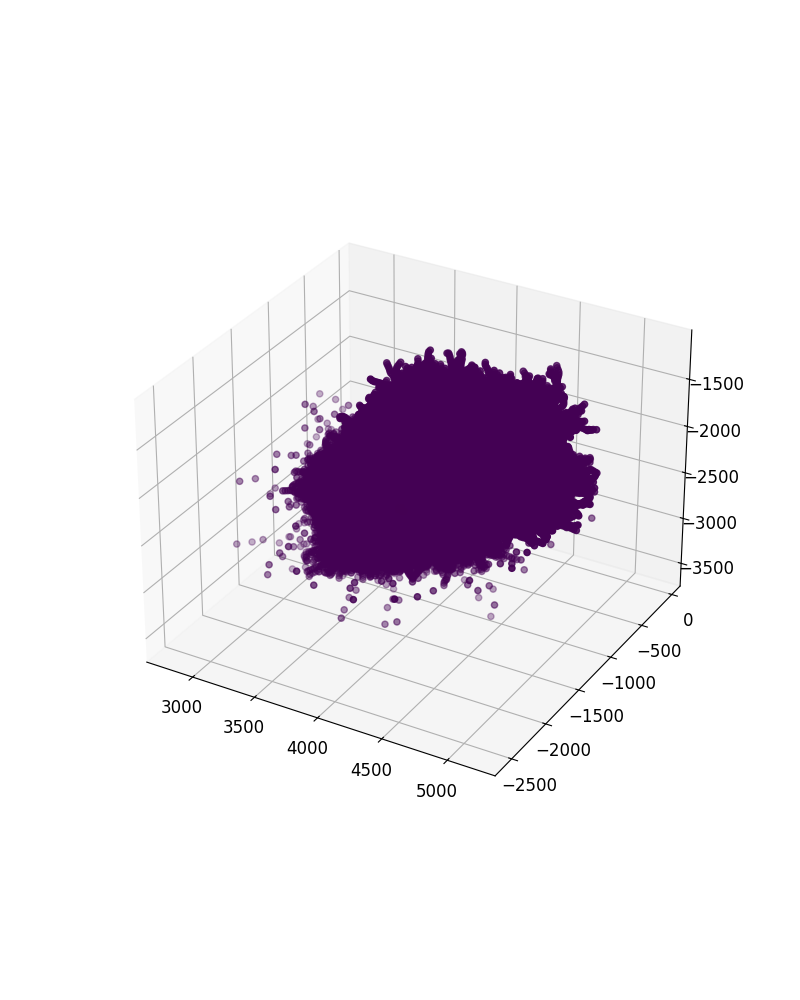

In [24]:
from matplotlib.gridspec import GridSpec


import types

plt.rcParams['axes.formatter.useoffset'] = False

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(projection='3d')

# gs = GridSpec(4, 6, figure=fig)
# ax1 = fig.add_subplot(gs[:-2, 0:3],projection='3d')
# ax2 = fig.add_subplot(gs[:-2, 3:],projection='3d')
# ax3 = fig.add_subplot(gs[-2, 0:2])
# ax4 = fig.add_subplot(gs[-2, 2:4])
# ax5 = fig.add_subplot(gs[-2, 4:])
# ax6 = fig.add_subplot(gs[-1, 0:2])
# ax7 = fig.add_subplot(gs[-1, 2:4])
# ax8 = fig.add_subplot(gs[-1, 4:])

#####
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG
for i in ids:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = SphereFull
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index][:,20]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax1.scatter(p[0],p[1],p[2],marker=marker,c=scale,vmin=0,vmax=5e-9)

